In [ ]:
pip install stellargraph

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:102: DeprecationWarning: Call to deprecated `syn0` (Attribute will be removed in 4.0.0, use self.wv.vectors instead).


StellarGraph: Directed multigraph
 Nodes: 1791489, Edges: 28511807

 Node types:
  article: [1791489]
    Features: float32 vector, length 100
    Edge types: article-link->article

 Edge types:
    article-link->article: [28511807]
        Weights: all 1 (default)
        Features: none
Epoch 1/15
168/168 [==============================] - 258s 2s/step - loss: 2.7261 - acc: 0.3909 - val_loss: 1.9949 - val_acc: 0.7505
Epoch 2/15
168/168 [==============================] - 260s 2s/step - loss: 1.8881 - acc: 0.7595 - val_loss: 1.4616 - val_acc: 0.8133
Epoch 3/15
168/168 [==============================] - 256s 2s/step - loss: 1.3966 - acc: 0.8048 - val_loss: 1.0833 - val_acc: 0.8400
Epoch 4/15
168/168 [==============================] - 247s 1s/step - loss: 1.0501 - acc: 0.8329 - val_loss: 0.8450 - val_acc: 0.8486
Epoch 5/15
168/168 [==============================] - 240s 1s/step - loss: 0.8453 - acc: 0.8361 - val_loss: 0.6953 - val_acc: 0.8595
Epoch 6/15
168/168 [==========================

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

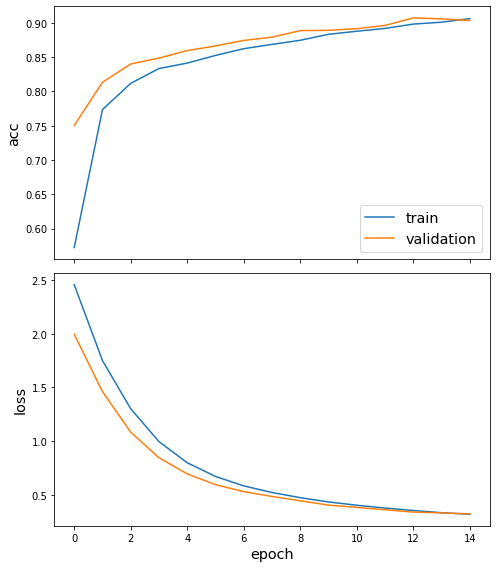

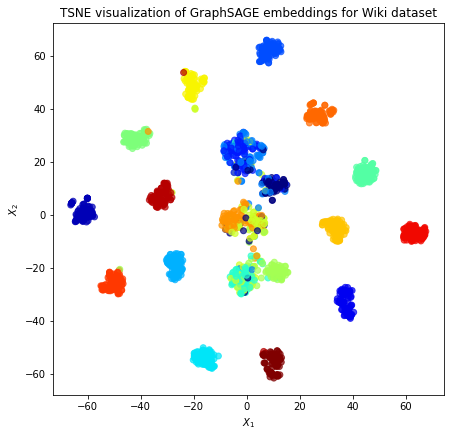

In [ ]:
import networkx as nx
import pandas as pd
import numpy as np
import os
from pandas import DataFrame
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

import nltk
nltk.download('punkt')
from gensim.models import word2vec
from collections import defaultdict
from sklearn.base import BaseEstimator, TransformerMixin


import stellargraph as sg
from stellargraph.mapper import GraphSAGENodeGenerator
from stellargraph.layer import GraphSAGE
from stellargraph.layer.graphsage import AttentionalAggregator,MaxPoolingAggregator,MeanAggregator,MeanPoolingAggregator

from tensorflow.keras import layers, optimizers, losses, metrics, Model
from sklearn import preprocessing, feature_extraction, model_selection
from stellargraph import datasets
from IPython.display import display, HTML
import matplotlib.pyplot as plt
%matplotlib inline

from google.colab import drive
drive.mount('/content/drive')
from google.colab import files

# Loading dataset
categories = pd.read_csv('/content/drive/My Drive/graph/categories.txt', delimiter=" ",  header=None, names=["cat","title"])
train = pd.read_csv('/content/drive/My Drive/graph/train.txt', delimiter=" ",  header=None,names=["node","cat"])
vali = pd.read_csv('/content/drive/My Drive/graph/val.txt', delimiter=" ",  header=None,names=["node","cat"])
test = pd.read_csv('/content/drive/My Drive/graph/test.txt', delimiter=" ",  header=None,names=["node"])
csvEdges = pd.read_table('/content/drive/My Drive/graph/network.txt', delimiter=" ",  header=None,names=["source","target"])
titles = open("/content/drive/My Drive/graph/titles.txt", "r")
t = []
for i in titles:
  t.append(i.strip())
u = []
for i in t:
  u.append(i.split(" "))
o = [" ".join (o[1:])  for o in u ]
data = DataFrame (o,columns=['text'])
data["node"] = range(0,len(o))

train=train.set_index("node")
vali=vali.set_index("node")
test=test.set_index("node")

# Node_features file is already downloaded, you can use it if you want to skip "Creating node features with word2vec method" section. 

# node_data = pd.read_csv('/content/drive/My Drive/graph/node_features.csv')
# node_data = node_data.drop(node_data.columns[0], axis=1) 

# Creating node features with word2vec method from titles.txt
class MyTokenizer:
    def __init__(self):
        pass

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        transformed_X = []
        for document in X:
            tokenized_doc = []
            for sent in nltk.sent_tokenize(document):
                tokenized_doc += nltk.word_tokenize(sent)
            transformed_X.append(tokenized_doc)
        return transformed_X

    def fit_transform(self, X, y=None):
        return self.transform(X)

class Vectorizer(object):
    def __init__(self, data):
        self.data = data
        self.tokenized_corpus = MyTokenizer().fit_transform(data['text'])

    def fit(self, X, y = None):
        return self

    def transform(self, X):
        pass

class MeanEmbeddingVectorizer(Vectorizer):
    def __init__(self, data):
        super().__init__(data)
        # Set values for various parameters
        self.feature_size = 100    # Word vector dimensionality
        self.window_context = 10  # Context window size
        self.min_word_count = 1   # Minimum word count
        self.sample = 1e-3   # Downsample setting for frequent words

        w2v_model = word2vec.Word2Vec(self.tokenized_corpus, size=self.feature_size,
                                window=self.window_context, min_count=self.min_word_count,
                                sample=self.sample, iter=50)

        self.word2vec = dict(zip(w2v_model.wv.index2word, w2v_model.wv.syn0))
        # if a text is empty we should return a vector of zeros
        # with the same dimensionality as all the other vectors
        self.dim = len(list(self.word2vec.values())[0])

    def transform(self, X):
        X = MyTokenizer().fit_transform(X)
        return np.array([
            np.mean([self.word2vec[w] for w in words if w in self.word2vec]
                    or [np.zeros(self.dim)], axis=0)
            for words in X
        ])

class VectorizerMixin(TransformerMixin, BaseEstimator):
    def __init__(self, model, data):
        self.model = model(data)

    def fit(self, X, y = None):
        return self.model.fit(X, y)

    def transform(self, X, y = None):
        return self.model.transform(X)
allNodes=np.union1d(csvEdges.source.unique(),csvEdges.target.unique())
result = VectorizerMixin(MeanEmbeddingVectorizer, data)
node_data = result.fit_transform(X=data['text'])
node_data = pd.DataFrame(node_data, index=allNodes)

# Node classification with directed GraphSAGE
g= sg.StellarGraph({"article": node_data}, {"link": csvEdges},is_directed=True,node_type_default="int32")
print(g.info())
# Converting to numeric arrays
target_encoding = preprocessing.LabelBinarizer()
train_targets = target_encoding.fit_transform(train)
vali_targets = target_encoding.transform(vali)

# Creating the GraphSAGE model in Keras

# We need two other parameters, the batch_size to use for training and the number of nodes to sample at each level of the model.
# Here we choose a two-level model with 100 nodes sampled in the first layer 50, and 50 in the second layer. 
batch_size = 100
num_samples = [50, 50]

# A DirectedGraphSAGENodeGenerator object is required to send the node features in sampled subgraphs to Keras
generator = GraphSAGENodeGenerator(g, batch_size, num_samples)

# Using the generator.flow() method, we can create iterators over nodes that should be used to train, validate, or evaluate the model.
# For training we use only the training nodes returned from our splitter and the target values. The shuffle=True argument is given to the flow method to improve training.
train_gen = generator.flow(train.index, train_targets, shuffle=True)

# Now, we can specify our machine learning model, we need a few more parameters for this:
# the layer_sizes is a list of hidden feature sizes of each layer in the model.The bias and dropout are internal parameters of the model.
graphsage_model = GraphSAGE(
    layer_sizes=[64, 32], generator=generator, bias=True, dropout=0.2,activations=["tanh","tanh"],
    aggregator=MaxPoolingAggregator
)

# Now, we create a model to predict the 20 categories using Keras softmax layers.
x_inp, x_out = graphsage_model.in_out_tensors()
prediction = layers.Dense(units=train_targets.shape[1], activation="softmax")(x_out)

# Training the model

# Now, let’s create the actual Keras model with the graph inputs x_inp provided by the graph_model and outputs being the predictions from the softmax layer
model = Model(inputs=x_inp, outputs=prediction)
model.compile(
    optimizer=optimizers.Adam(lr=0.001),
    loss=losses.categorical_crossentropy,
    metrics=["acc"],
)
# Train the model, keeping track of its loss and accuracy on the training set, and its generalisation performance on the val set (we need to create another generator over the val data for this)
vali_gen = generator.flow(vali.index, vali_targets)

history = model.fit(
    train_gen, epochs = 15, validation_data=vali_gen, verbose=1, shuffle=True
)
sg.utils.plot_history(history)

# Now, we have trained the model we can evaluate on the test set. Our test file doesn't have labels.
# so, I just write the code here but use val_gen again to see the accuracy. Then, I will predict labels of test nodes and will save the result.

test_metrics = model.evaluate(vali_gen)
print("\nVal Set Metrics:")
for name, val in zip(model.metrics_names, test_metrics):
    print("\t{}: {:0.4f}".format(name, val))


# If you want to have accuracy on test file, you should read  the test file(with category) and run following section. Please modify the file name!
# test = pd.read_csv('/content/drive/My Drive/graph/testwithcat.txt', delimiter=" ",  header=None,names=["node","cat"])
# test=test.set_index("node")
# test_gen = generator.flow(test_subjects.index, test_targets)
# test_metrics = model.evaluate(test_gen)
# print("\nTest Set Metrics:")
# for name, val in zip(model.metrics_names, test_metrics):
#     print("\t{}: {:0.4f}".format(name, val))


# Making predictions with the model
# Now let’s get the predictions themselves for all nodes using another node iterator:
test_nodes = test.index
all_mapper = generator.flow(test_nodes)
all_predictions = model.predict(all_mapper)
# These predictions will be the output of the softmax layer, so to get final categories we’ll use the inverse_transform method of our target attribute specification to turn these values back to the original categories
node_predictions = target_encoding.inverse_transform(all_predictions)

# If we want to see the text of 20 categories
df = pd.DataFrame({"node":test_nodes, "cat": node_predictions})
test_predicted_cat = pd.merge(df,categories, on ='cat', how ='left') # This file can be found in the folder

# Save result into txt format

df.to_csv('predictions.txt', index= False, header=None, sep=' ') 
files.download('predictions.txt')


# Node embeddings
# Evaluate node embeddings as activations of the output of GraphSAGE layer stack, and visualise them, coloring nodes by their subject label.
# The GraphSAGE embeddings are the output of the GraphSAGE layers, namely the x_out variable.
# Let’s create a new model with the same inputs as we used previously x_inp but now the output is the embeddings rather than the predicted class.
# Additionally note that the weights trained previously are kept in the new model.

#*** For illustration purpose, I use val.txt, but if the test.txt have lables, we can plot the test file.
all_nodes = vali.index
all_mapper = generator.flow(all_nodes)
embedding_model = Model(inputs=x_inp, outputs=x_out)
emb = embedding_model.predict(all_mapper)

# Project the embeddings to 2d using either TSNE or PCA transform, and visualise, coloring nodes by their subject label
X = emb
y = np.argmax(target_encoding.transform(vali.cat), axis=1)
if X.shape[1] > 2:
    transform = TSNE  # PCA

    trans = transform(n_components=2)
    emb_transformed = pd.DataFrame(trans.fit_transform(X), index=vali.index)
    emb_transformed["label"] = y
else:
    emb_transformed = pd.DataFrame(X, index=node_subjects.index)
    emb_transformed = emb_transformed.rename(columns={"0": 0, "1": 1})
    emb_transformed["label"] = y
alpha = 0.7

fig, ax = plt.subplots(figsize=(7, 7))
ax.scatter(
    emb_transformed[0],
    emb_transformed[1],
    c=emb_transformed["label"].astype("category"),
    cmap="jet",
    alpha=alpha,
)
ax.set(aspect="equal", xlabel="$X_1$", ylabel="$X_2$")
plt.title(
    "{} visualization of GraphSAGE embeddings for Wiki dataset".format(transform.__name__)
)
plt.show()
